In [1]:
import sys
import untangle
import socnet as sn
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats.stats import pearsonr
from scipy.optimize import minimize
from scipy import stats

In [2]:
def normalize_list(l):
    dmin = min(l)
    dmax = max(l)
    print(dmin, " , ", dmax)
    print(1/dmax)
    result = []
    for i in l:
        result.append((i - dmin) / (dmax - dmin))
    
    
    return result

In [3]:
tags = untangle.parse("./data/Tags.xml")
postHist = untangle.parse("./data/PostHistory.xml")
posts = untangle.parse("./data/Posts.xml")
users = untangle.parse("./data/Users.xml")
votes = untangle.parse("./data/Votes.xml")

In [4]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 0.5
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

In [5]:
#{userid : [postid1, postid2]} - userposts
#{postid : parentpost} - parent
#{postid : user} - postuser
#{userid : displayname} - username
#{userid : reputation} - userrep
#{normalizedid : userid} normalizedid = {}
#[(userid, userid)] - edges

userposts = {}
parent = {}
postuser = {}
username = {}
userrep = {}
normalizedid = {}
edges = []

fakes = {"user306": "9001", "user2508039": "9002", "Shireen": "2047"}
fakerep = [0,0,66]
#There are 3 users that appears names on posts references, but are not mentioned anywhere else  
#we added them to a unique dictionary so they would not colapse the entire graph
#Shireen is actually a working user entry, but it seens the this user changed ts nickname so maybe thats why it also shows its
#old name in the post. Another postt she appears does not have the OwnerDisplayName field

counter = 0
for i in users.users.row:
    normalizedid[counter] = i["Id"]
    userposts[i['Id']] = []
    username[i['Id']] = str(i['DisplayName'].encode("utf-8", 'xmlcharrefreplace')).strip("b'").strip("'").strip("\"")
    userrep[i['Id']] = int(i["Reputation"])
    counter +=1
freezeCounter = counter
for i in fakes.items():
    userposts[i[1]] = []
    username[i[1]] = i[0]
    username[i[1]] = i[0]
    userrep[i[1]] = fakerep[counter - freezeCounter]
    normalizedid[counter] = i[1]
    counter +=1 

for i in posts.posts.row:
    
    
    current_parent = None
    if i["PostTypeId"] == "2":
        current_parent = i["ParentId"]
    parent[i['Id']] = current_parent
    
    #Gerenciate (engrish pls) cases when there is a wierd name instead of id, as represented in <Dict>fakes
    if(i["OwnerUserId"]) == None:
        postuser[i["Id"]] = fakes[i["OwnerDisplayName"]]
        userposts[fakes[i["OwnerDisplayName"]]].append(i["Id"])
        
    else:
        postuser[i["Id"]] = i["OwnerUserId"]
        userposts[i["OwnerUserId"]].append(i["Id"])
    


In [6]:
#write gml

file = open("quantum_V01.gml", "w")
file.write('graph [\n')
file.write('  directed 1\n')

for i in userposts.keys():
    #print(username[i])
    file.write('  node [\n')
    file.write('    id {}\n'.format(i))
    file.write('    label "' + username[i] + '"\n')
    file.write('  ]\n')
    

edges = []
for i in userposts.keys():
    for post in userposts[i]:
        question = parent[post]
        if(question != None):
            if not (i,postuser[question]) in edges:
                edges.append((i,postuser[question]))
                #print(i, " - ", postuser[question])
                file.write('  edge [\n')
                file.write('    source {}\n'.format(i))
                file.write('    target {}\n'.format(postuser[question]))
                file.write('  ]\n')
            else:
                print("Avoided crisis  -  ",i, " - ", postuser[question])
file.write(']')
file.close()

Avoided crisis  -   18  -  27
Avoided crisis  -   23  -  26
Avoided crisis  -   23  -  26
Avoided crisis  -   23  -  55
Avoided crisis  -   23  -  253
Avoided crisis  -   23  -  26
Avoided crisis  -   23  -  2645
Avoided crisis  -   26  -  261
Avoided crisis  -   26  -  26
Avoided crisis  -   26  -  91
Avoided crisis  -   26  -  609
Avoided crisis  -   26  -  26
Avoided crisis  -   26  -  2559
Avoided crisis  -   26  -  2559
Avoided crisis  -   26  -  2559
Avoided crisis  -   26  -  2559
Avoided crisis  -   26  -  26
Avoided crisis  -   26  -  2529
Avoided crisis  -   26  -  3035
Avoided crisis  -   54  -  1658
Avoided crisis  -   54  -  409
Avoided crisis  -   54  -  2371
Avoided crisis  -   55  -  261
Avoided crisis  -   55  -  104
Avoided crisis  -   55  -  580
Avoided crisis  -   55  -  1931
Avoided crisis  -   55  -  2293
Avoided crisis  -   55  -  2645
Avoided crisis  -   91  -  253
Avoided crisis  -   91  -  2645
Avoided crisis  -   104  -  91
Avoided crisis  -   119  -  2100
Av

In [7]:
nodes_raw = sn.load_graph('quantum_V01.gml', has_pos=False)
for i in range(len(edges)):
    edges[i] =  (int(edges[i][0]),int(edges[i][1]))
    
nodes = nx.edge_subgraph(nodes_raw, edges)
nodes = nodes.reverse()

#Perguntas aceitas
#Para mudar a analise para o grafo de arestas dadas por pergunta escolhida, altere a variavel flag abaixo para True
flag = True

accepted = [] #{postid : acceptedanswerid}
for i in posts.posts.row:
    if(i["AcceptedAnswerId"] != None):
        accepted.append((int(postuser[i["Id"]]),int(postuser[i["AcceptedAnswerId"]])))
anodes = nx.edge_subgraph(nodes, accepted)

if(flag):
    nodes = anodes

sn.show_graph(nodes, nlab=False)


C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:59: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:187: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:188: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:189: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
sn.show_graph(nodes, nlab=True)

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:59: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:187: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:188: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:189: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean Low\Documents\GitHub\StackERedes\socnet.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [9]:

print(accepted[:10])
print(len(accepted))
print(edges[0:10])
print(len(edges))
print(nx.number_of_edges(nodes))

[(7, 15), (13, 26), (14, 15), (31, 162), (40, 7), (61, 54), (45, 18), (67, 23), (91, 32), (99, 138)]
389
[(7, 40), (11, 27), (13, 27), (13, 11), (13, 253), (15, 7), (15, 14), (15, 26), (15, 82), (15, 236)]
835
301


In [10]:
#listing how many questions were asked/answered by a certain user

(Counter(elem[0] for elem in edges))

Counter({7: 1,
         11: 1,
         13: 3,
         15: 9,
         18: 5,
         23: 20,
         24: 4,
         26: 36,
         27: 2,
         29: 1,
         32: 4,
         35: 1,
         39: 1,
         54: 13,
         55: 32,
         67: 1,
         70: 2,
         72: 2,
         82: 1,
         86: 2,
         91: 14,
         99: 2,
         104: 9,
         119: 26,
         124: 33,
         127: 2,
         138: 2,
         144: 3,
         162: 2,
         171: 1,
         176: 1,
         197: 4,
         236: 2,
         238: 4,
         253: 10,
         263: 6,
         274: 4,
         278: 22,
         299: 1,
         302: 3,
         356: 3,
         362: 2,
         391: 5,
         407: 1,
         409: 57,
         410: 3,
         419: 4,
         422: 1,
         429: 3,
         434: 11,
         483: 4,
         484: 1,
         491: 13,
         505: 1,
         506: 1,
         522: 1,
         534: 3,
         551: 4,
         563: 2,
        

In [11]:
#sorting user id by reputation

userrepSort = sorted(userrep.items(), key=lambda kv: kv[1], reverse=True)
userrepSort

[('1837', 7477),
 ('26', 5220),
 ('409', 5102),
 ('124', 3993),
 ('2293', 3655),
 ('55', 2888),
 ('23', 2081),
 ('119', 2016),
 ('91', 1878),
 ('1847', 1584),
 ('278', 1460),
 ('1039', 1444),
 ('253', 1328),
 ('54', 1299),
 ('15', 1145),
 ('1386', 1119),
 ('104', 1092),
 ('2645', 955),
 ('1764', 854),
 ('2559', 759),
 ('7', 758),
 ('18', 750),
 ('32', 724),
 ('391', 717),
 ('1234', 715),
 ('144', 705),
 ('138', 675),
 ('238', 663),
 ('2371', 663),
 ('2105', 612),
 ('434', 595),
 ('11', 573),
 ('236', 570),
 ('491', 564),
 ('1974', 537),
 ('3056', 520),
 ('2529', 488),
 ('2015', 482),
 ('4127', 480),
 ('162', 473),
 ('2503', 473),
 ('72', 464),
 ('362', 442),
 ('2100', 442),
 ('13', 440),
 ('2663', 431),
 ('99', 422),
 ('2648', 421),
 ('429', 410),
 ('27', 394),
 ('1955', 393),
 ('356', 391),
 ('551', 390),
 ('58', 388),
 ('40', 387),
 ('274', 386),
 ('1905', 384),
 ('2927', 381),
 ('39', 377),
 ('197', 376),
 ('2879', 366),
 ('1658', 361),
 ('769', 357),
 ('1931', 355),
 ('4211', 355),

In [12]:
#betweenness for nodes with edges (values must be > 0)

bc = nx.betweenness_centrality(nodes)

In [13]:
#closeness for nodes with edges (values must be > 0)

clos = nx.closeness_centrality(nodes)
closDict = {}
        
sortDictC = sorted([(v,k) for k,v in clos.items()], reverse = True)
sortDictC

[(0.25600819478370496, 2293),
 (0.2484673711381786, 124),
 (0.2430998831250562, 1837),
 (0.23482414242292662, 26),
 (0.2212311932072099, 23),
 (0.19294990723562153, 54),
 (0.1827273955939992, 409),
 (0.17180372148859543, 32),
 (0.1694277108433735, 2547),
 (0.16773153030209045, 1386),
 (0.16642011834319526, 491),
 (0.165929203539823, 356),
 (0.16544117647058823, 4294),
 (0.16544117647058823, 263),
 (0.16374977290619513, 4127),
 (0.14794550527985995, 119),
 (0.1422458384275369, 1764),
 (0.14168765743073047, 1234),
 (0.13521589191232047, 3056),
 (0.13028756957328386, 2503),
 (0.06351161154116819, 55),
 (0.050235478806907374, 1847),
 (0.045, 238),
 (0.037569573283859, 278),
 (0.02040816326530612, 434),
 (0.02040816326530612, 104),
 (0.02040816326530612, 91),
 (0.01923076923076923, 2663),
 (0.016326530612244896, 15),
 (0.015306122448979591, 2105),
 (0.015306122448979591, 1813),
 (0.015306122448979591, 1039),
 (0.015306122448979591, 24),
 (0.013605442176870746, 2371),
 (0.013605442176870746,

In [14]:
pr = nx.pagerank(nodes)
prNamed = {}
    
prNamedSorted = sorted(pr.items(), key=lambda kv: kv[1], reverse=True)
prNamedSorted

[(2293, 0.2056350770610024),
 (1837, 0.06595959983615322),
 (409, 0.05589134294889579),
 (26, 0.04577979181294506),
 (124, 0.03234263089533988),
 (1764, 0.026404382009218436),
 (23, 0.026267997098838862),
 (119, 0.021464796755498464),
 (2547, 0.020448211084781037),
 (54, 0.019901385261392342),
 (2047, 0.011697994573992114),
 (1234, 0.011642324752665622),
 (55, 0.010833776632403041),
 (1847, 0.010361825714590342),
 (1386, 0.0078014182140794565),
 (3056, 0.007149885466251838),
 (32, 0.006711155923377067),
 (15, 0.006512786933954156),
 (434, 0.006425515454333458),
 (278, 0.0063601239067509205),
 (238, 0.00555354688168022),
 (356, 0.005498431315435633),
 (2105, 0.005491872117045421),
 (18, 0.00537990063397443),
 (491, 0.00524945975882549),
 (104, 0.005078017145134334),
 (4127, 0.005000488202215347),
 (4294, 0.005000488202215347),
 (263, 0.005000488202215347),
 (2503, 0.004966899457645563),
 (1034, 0.004744957447214992),
 (138, 0.004315514370764282),
 (24, 0.0042470143339947055),
 (391, 0.0

In [15]:

prlist = []
replist = []
idlist = []


for i in pr.items():
    #print("id = ",  )
    prlist.append(i[1])
    idlist.append(i[0])
    replist.append(userrep[str(i[0])])


    

for i in range(len(idlist)):
    print(idlist[i]," --> rep = ", replist[i], " | pr = ", prlist[i])
    pass

2563  --> rep =  28  | pr =  0.0017572987678932742
2054  --> rep =  33  | pr =  0.0017572987678932742
7  --> rep =  758  | pr =  0.003251128107554133
1034  --> rep =  281  | pr =  0.004744957447214992
11  --> rep =  573  | pr =  0.0017572987678932742
522  --> rep =  56  | pr =  0.0025042134377237036
13  --> rep =  440  | pr =  0.0017572987678932742
14  --> rep =  149  | pr =  0.0017572987678932742
1039  --> rep =  1444  | pr =  0.0038113141099269544
528  --> rep =  201  | pr =  0.0017572987678932742
15  --> rep =  1145  | pr =  0.006512786933954156
18  --> rep =  750  | pr =  0.00537990063397443
3088  --> rep =  28  | pr =  0.0017572987678932742
1044  --> rep =  148  | pr =  0.0017572987678932742
2060  --> rep =  88  | pr =  0.0017572987678932742
2061  --> rep =  138  | pr =  0.0017572987678932742
23  --> rep =  2081  | pr =  0.026267997098838862
24  --> rep =  286  | pr =  0.0042470143339947055
26  --> rep =  5220  | pr =  0.04577979181294506
31  --> rep =  250  | pr =  0.001757298767

In [39]:
prnodes = []
repforprnodes = []

for i in pr.items():
    if(i[1] > 0):
        prnodes.append(i[1])
        repforprnodes.append(userrep[str(i[0])])

for i in range(len(prnodes)):
    print(prnodes[i], "-",repforprnodes[i])

0.0017572987678932742 - 28
0.0017572987678932742 - 33
0.003251128107554133 - 758
0.004744957447214992 - 281
0.0017572987678932742 - 573
0.0025042134377237036 - 56
0.0017572987678932742 - 440
0.0017572987678932742 - 149
0.0038113141099269544 - 1444
0.0017572987678932742 - 201
0.006512786933954156 - 1145
0.00537990063397443 - 750
0.0017572987678932742 - 28
0.0017572987678932742 - 148
0.0017572987678932742 - 88
0.0017572987678932742 - 138
0.026267997098838862 - 2081
0.0042470143339947055 - 286
0.04577979181294506 - 5220
0.0017572987678932742 - 250
0.006711155923377067 - 724
0.005000488202215347 - 480
0.0017572987678932742 - 138
0.0025042134377237036 - 390
0.0017572987678932742 - 387
0.0017572987678932742 - 78
0.0017572987678932742 - 221
0.0017572987678932742 - 133
0.0017572987678932742 - 186
0.003251128107554133 - 442
0.0017572987678932742 - 76
0.019901385261392342 - 1299
0.010833776632403041 - 2888
0.005491872117045421 - 612
0.0017572987678932742 - 388
0.0017572987678932742 - 48
0.001757

In [40]:

stats.ttest_rel([x * 100000 for x in prnodes],[y * 1 for y in repforprnodes])

#for i in range(len(btwnodes)):
 #   print(x[i], " | ",y[i])

Ttest_relResult(statistic=0.8168167202337252, pvalue=0.4150248748930343)

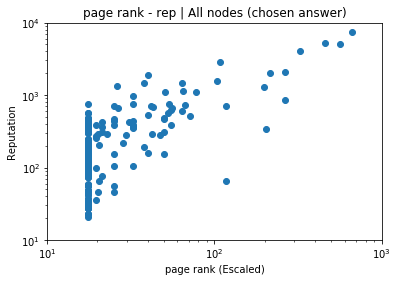

In [41]:
#All nodes
plt.axis([10,1000,10,10000])
ax = plt.gca()
ax.scatter([x * 10000 for x in prnodes],repforprnodes)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("page rank - rep | All nodes (chosen answer)")
plt.xlabel("page rank (Escaled)")
plt.ylabel("Reputation")
plt.show()

In [19]:
#Filter low betweennes and != 0
bcnozero = {}
for i in bc.items():
    if(i[1] > 0):
        bcnozero[i[0]] = i[1]
lowfilterbc = []
lowfilterbc = sorted(bcnozero.items(), key=lambda kv: kv[1], reverse=False)[:int((len(bcnozero.items())/2))]
print(len(bcnozero))
print(len(lowfilterbc))
print(max(bc.values()))
print(lowfilterbc)


lowbcpr = []
repforlowbcpr = []

for i in lowfilterbc:
    lowbcpr.append(pr[i[0]])
    repforlowbcpr.append(userrep[str(i[0])])

for i in range(len(lowbcpr)):
    print(lowbcpr[i], "-",repforlowbcpr[i])
    

29
14
0.03518663875806733
[(1658, 6.541077969649398e-06), (7, 2.6164311878597592e-05), (551, 2.6164311878597592e-05), (162, 2.6164311878597592e-05), (2927, 5.2328623757195185e-05), (673, 0.00010465724751439037), (99, 0.00013954299668585384), (91, 0.00017006802721088434), (2371, 0.00024420024420024415), (144, 0.0004796790511076226), (2100, 0.0005232862375719519), (391, 0.0006279434850863422), (1234, 0.000641025641025641), (2645, 0.0007849293563579277)]
0.002130756102808489 - 361
0.003251128107554133 - 758
0.0025042134377237036 - 390
0.0025042134377237036 - 473
0.0019547070331203983 - 381
0.002130756102808489 - 312
0.002130756102808489 - 422
0.004024718301307077 - 1878
0.0026611179228287945 - 663
0.0025031888346218564 - 705
0.003251128107554133 - 442
0.004154947262489652 - 717
0.011642324752665622 - 715
0.003251128107554133 - 955


In [20]:
stats.ttest_rel([x * 100000 for x in lowbcpr],[y * 1 for y in repforlowbcpr])

Ttest_relResult(statistic=-2.8016966799861223, pvalue=0.014980989295656692)

[213.07561028084888, 325.1128107554133, 250.42134377237036, 250.42134377237036, 195.47070331203983, 213.07561028084888, 213.07561028084888, 402.47183013070776, 266.11179228287943, 250.31888346218562, 325.1128107554133, 415.49472624896526, 1164.2324752665622, 325.1128107554133]
[0.002130756102808489, 0.003251128107554133, 0.0025042134377237036, 0.0025042134377237036, 0.0019547070331203983, 0.002130756102808489, 0.002130756102808489, 0.004024718301307077, 0.0026611179228287945, 0.0025031888346218564, 0.003251128107554133, 0.004154947262489652, 0.011642324752665622, 0.003251128107554133]


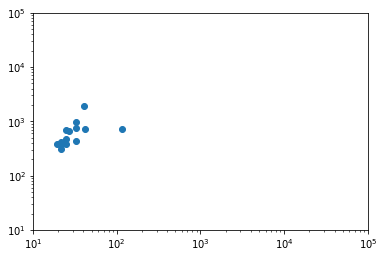

In [21]:
print([x * 100000 for x in lowbcpr])
print(lowbcpr)
plt.axis([10,100000,10,100000])
ax = plt.gca()
ax.scatter([x * 10000 for x in lowbcpr],repforlowbcpr)
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [22]:
#Filter betweennes != 0
bcnozero = {}
for i in bc.items():
    if(i[1] > 0):
        bcnozero[i[0]] = i[1]
lowfilterbc = []
lowfilterbc = sorted(bcnozero.items(), key=lambda kv: kv[1], reverse=False)[:int((len(bcnozero.items())))]
print(len(bcnozero))
print(len(lowfilterbc))
print(max(bc.values()))
print(lowfilterbc)


lowbcpr = []
repforlowbcpr = []

for i in lowfilterbc:
    lowbcpr.append(pr[i[0]])
    repforlowbcpr.append(userrep[str(i[0])])

for i in range(len(lowbcpr)):
    print(lowbcpr[i], "-",repforlowbcpr[i])
    

29
29
0.03518663875806733
[(1658, 6.541077969649398e-06), (7, 2.6164311878597592e-05), (551, 2.6164311878597592e-05), (162, 2.6164311878597592e-05), (2927, 5.2328623757195185e-05), (673, 0.00010465724751439037), (99, 0.00013954299668585384), (91, 0.00017006802721088434), (2371, 0.00024420024420024415), (144, 0.0004796790511076226), (2100, 0.0005232862375719519), (391, 0.0006279434850863422), (1234, 0.000641025641025641), (2645, 0.0007849293563579277), (253, 0.0008350776207919064), (1039, 0.0008765044479330193), (138, 0.001024768881911739), (104, 0.001530612244897959), (278, 0.0016352694924123496), (2547, 0.002642595499738357), (4127, 0.002694924123495552), (1847, 0.002882435025292168), (55, 0.00442394906680621), (54, 0.005154369440083725), (1386, 0.007810047095761381), (119, 0.01085382871097157), (409, 0.016206610849467992), (1837, 0.022091400662829233), (26, 0.03518663875806733)]
0.002130756102808489 - 361
0.003251128107554133 - 758
0.0025042134377237036 - 390
0.0025042134377237036 - 

In [36]:
stats.ttest_rel([x * 100000 for x in lowbcpr],[y * 1 for y in repforlowbcpr])

Ttest_relResult(statistic=-2.5941949664838444, pvalue=0.014916780757354638)

[213.07561028084888, 325.1128107554133, 250.42134377237036, 250.42134377237036, 195.47070331203983, 213.07561028084888, 213.07561028084888, 402.47183013070776, 266.11179228287943, 250.31888346218562, 325.1128107554133, 415.49472624896526, 1164.2324752665622, 325.1128107554133, 262.8699216028775, 381.13141099269546, 431.55143707642816, 507.8017145134334, 636.0123906750921, 2044.8211084781037, 500.0488202215347, 1036.182571459034, 1083.3776632403042, 1990.1385261392343, 780.1418214079456, 2146.4796755498464, 5589.134294889579, 6595.959983615322, 4577.979181294506]
[0.002130756102808489, 0.003251128107554133, 0.0025042134377237036, 0.0025042134377237036, 0.0019547070331203983, 0.002130756102808489, 0.002130756102808489, 0.004024718301307077, 0.0026611179228287945, 0.0025031888346218564, 0.003251128107554133, 0.004154947262489652, 0.011642324752665622, 0.003251128107554133, 0.002628699216028775, 0.0038113141099269544, 0.004315514370764282, 0.005078017145134334, 0.0063601239067509205, 0.020

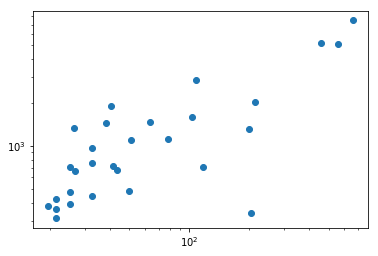

In [24]:

print([x * 100000 for x in lowbcpr])
print(lowbcpr)
#plt.axis([10,1000,10,10000])
ax = plt.gca()
ax.scatter([x * 10000 for x in lowbcpr],repforlowbcpr)
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [25]:
#Filter high betweennes
bcnozero = {}
for i in bc.items():
    if(i[1] > 0):
        bcnozero[i[0]] = i[1]
highfilterbc = []
highfilterbc = sorted(bcnozero.items(), key=lambda kv: kv[1], reverse=True)[:int((len(bcnozero.items())/2))]
print(len(bcnozero))
print(len(highfilterbc))
print(max(bc.values()))
print(highfilterbc)


highbcpr = []
repforhighbcpr = []

for i in highfilterbc:
    highbcpr.append(pr[i[0]])
    repforhighbcpr.append(userrep[str(i[0])])

for i in range(len(highbcpr)):
    print(highbcpr[i], "-",repforhighbcpr[i])
    

29
14
0.03518663875806733
[(26, 0.03518663875806733), (1837, 0.022091400662829233), (409, 0.016206610849467992), (119, 0.01085382871097157), (1386, 0.007810047095761381), (54, 0.005154369440083725), (55, 0.00442394906680621), (1847, 0.002882435025292168), (4127, 0.002694924123495552), (2547, 0.002642595499738357), (278, 0.0016352694924123496), (104, 0.001530612244897959), (138, 0.001024768881911739), (1039, 0.0008765044479330193)]
0.04577979181294506 - 5220
0.06595959983615322 - 7477
0.05589134294889579 - 5102
0.021464796755498464 - 2016
0.0078014182140794565 - 1119
0.019901385261392342 - 1299
0.010833776632403041 - 2888
0.010361825714590342 - 1584
0.005000488202215347 - 480
0.020448211084781037 - 338
0.0063601239067509205 - 1460
0.005078017145134334 - 1092
0.004315514370764282 - 675
0.0038113141099269544 - 1444


In [26]:
stats.ttest_rel([x * 100000 for x in highbcpr],[y * 1 for y in repforhighbcpr])

Ttest_relResult(statistic=-1.2088053051884065, pvalue=0.2482652004296304)

[4577.979181294506, 6595.959983615322, 5589.134294889579, 2146.4796755498464, 780.1418214079456, 1990.1385261392343, 1083.3776632403042, 1036.182571459034, 500.0488202215347, 2044.8211084781037, 636.0123906750921, 507.8017145134334, 431.55143707642816, 381.13141099269546]
[0.04577979181294506, 0.06595959983615322, 0.05589134294889579, 0.021464796755498464, 0.0078014182140794565, 0.019901385261392342, 0.010833776632403041, 0.010361825714590342, 0.005000488202215347, 0.020448211084781037, 0.0063601239067509205, 0.005078017145134334, 0.004315514370764282, 0.0038113141099269544]


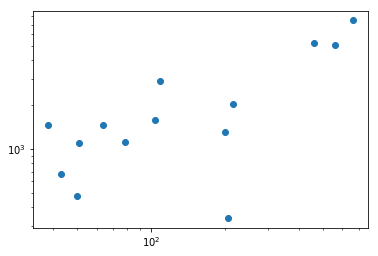

In [27]:
print([x * 100000 for x in highbcpr])
print(highbcpr)
#plt.axis([10,1000,10,10000])
ax = plt.gca()
ax.scatter([x * 10000 for x in highbcpr],repforhighbcpr)
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [28]:
#Filter betweennes == 0
bczero = {}
for i in bc.items():
    if(i[1] == 0):
        bczero[i[0]] = i[1]
zerofilterbc = []
zerofilterbc = sorted(bczero.items(), key=lambda kv: kv[1], reverse=True)[:int((len(bczero.items())))]
print(len(bczero))
print(len(zerofilterbc))
print(max(bc.values()))
print(zerofilterbc)


zerobcpr = []
repforzerobcpr = []

for i in zerofilterbc:
    zerobcpr.append(pr[i[0]])
    repforzerobcpr.append(userrep[str(i[0])])

for i in range(len(zerobcpr)):
    print(zerobcpr[i], "-",repforzerobcpr[i])
    

168
168
0.03518663875806733
[(2563, 0.0), (2054, 0.0), (1034, 0.0), (11, 0.0), (522, 0.0), (13, 0.0), (14, 0.0), (528, 0.0), (15, 0.0), (18, 0.0), (3088, 0.0), (1044, 0.0), (2060, 0.0), (2061, 0.0), (23, 0.0), (24, 0.0), (31, 0.0), (32, 0.0), (2080, 0.0), (40, 0.0), (2601, 0.0), (45, 0.0), (1581, 0.0), (2098, 0.0), (1589, 0.0), (2105, 0.0), (58, 0.0), (4153, 0.0), (61, 0.0), (4160, 0.0), (2624, 0.0), (67, 0.0), (1092, 0.0), (580, 0.0), (72, 0.0), (2559, 0.0), (2637, 0.0), (82, 0.0), (4178, 0.0), (4181, 0.0), (86, 0.0), (2648, 0.0), (2136, 0.0), (92, 0.0), (1115, 0.0), (609, 0.0), (2663, 0.0), (1644, 0.0), (2160, 0.0), (4210, 0.0), (4211, 0.0), (124, 0.0), (2687, 0.0), (127, 0.0), (4232, 0.0), (2201, 0.0), (2713, 0.0), (2209, 0.0), (1185, 0.0), (4259, 0.0), (4263, 0.0), (689, 0.0), (4275, 0.0), (699, 0.0), (4287, 0.0), (2757, 0.0), (4294, 0.0), (197, 0.0), (4298, 0.0), (2771, 0.0), (2782, 0.0), (1764, 0.0), (1254, 0.0), (2794, 0.0), (236, 0.0), (238, 0.0), (2287, 0.0), (2290, 0.0), (177

In [29]:
stats.ttest_rel([x * 100000 for x in zerobcpr],[y * 1 for y in repforzerobcpr])

Ttest_relResult(statistic=1.3854714270545818, pvalue=0.16775599072705433)

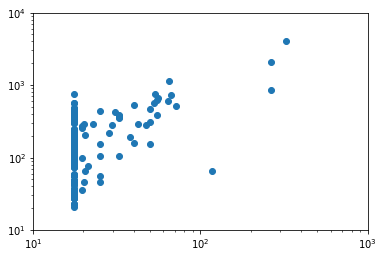

In [30]:
#print([x * 100000 for x in zerobcpr])
#print(zerobcpr)
plt.axis([10,1000,10,10000])
ax = plt.gca()
ax.scatter([x * 10000 for x in zerobcpr],repforzerobcpr)
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [31]:
#Teste com pr mais baixo e comum removido
prnodes = []
repforprnodes = []

for i in pr.items():
    if(i[1] > 0.0018):
        prnodes.append(i[1])
        repforprnodes.append(userrep[str(i[0])])

for i in range(len(prnodes)):
    print(prnodes[i], "-",repforprnodes[i])

0.003251128107554133 - 758
0.004744957447214992 - 281
0.0025042134377237036 - 56
0.0038113141099269544 - 1444
0.006512786933954156 - 1145
0.00537990063397443 - 750
0.026267997098838862 - 2081
0.0042470143339947055 - 286
0.04577979181294506 - 5220
0.006711155923377067 - 724
0.005000488202215347 - 480
0.0025042134377237036 - 390
0.003251128107554133 - 442
0.019901385261392342 - 1299
0.010833776632403041 - 2888
0.005491872117045421 - 612
0.002130756102808489 - 76
0.003251128107554133 - 955
0.0025042134377237036 - 46
0.0029801468338608093 - 285
0.004024718301307077 - 1878
0.002130756102808489 - 422
0.0030715407952737967 - 431
0.005078017145134334 - 1092
0.003251128107554133 - 355
0.021464796755498464 - 2016
0.002130756102808489 - 361
0.03234263089533988 - 3993
0.0025042134377237036 - 104
0.004315514370764282 - 675
0.0025031888346218564 - 705
0.002130756102808489 - 312
0.0025042134377237036 - 473
0.0019547070331203983 - 254
0.003251128107554133 - 106
0.005000488202215347 - 156
0.00325112810

In [32]:

stats.ttest_rel([x * 100000 for x in prnodes],[y * 1 for y in repforprnodes])

#for i in range(len(btwnodes)):
 #   print(x[i], " | ",y[i])

Ttest_relResult(statistic=0.6658774201921166, pvalue=0.507588187906774)

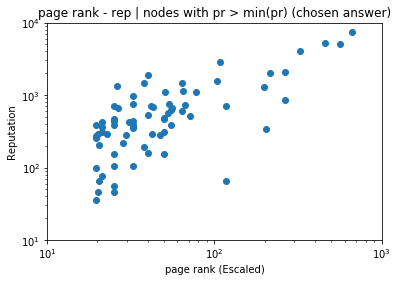

In [38]:
plt.axis([10,1000,10,10000])
ax = plt.gca()
ax.scatter([x * 10000 for x in prnodes],repforprnodes)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("page rank - rep | nodes with pr > min(pr) (chosen answer)")
plt.xlabel("page rank (Escaled)")
plt.ylabel("Reputation")
plt.show()